In [2]:
%pip install openpyxl
from tabulate import tabulate
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates
from datetime import datetime, timedelta


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
from statsmodels.tsa.api import VAR

import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm


import warnings
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', HessianInversionWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

sns.set_theme()


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [24]:
#import our data
Carbon_Pricing = pd.read_excel('C:\\Users\\oscar.smith\\Desktop\\xlsx\\Energy Markets Data.xlsx')
Emissions_Data = pd.read_csv("C:\\Users\\oscar.smith\\Desktop\\xlsx\\co2_emissions_CREA.csv")
Carbon_Pricing.ECARBIX
Carbon_values = pd.Series(Carbon_Pricing.ECARBIX)
Carbon_values.index = pd.to_datetime(Carbon_Pricing.Date)
Carbon_values



Date
2023-10-02    80.93
2023-10-03    79.18
2023-10-04    80.96
2023-10-05    80.50
2023-10-06    79.97
              ...  
2024-07-29    67.58
2024-07-30    66.55
2024-07-31    67.81
2024-08-01    68.07
2024-08-02    69.76
Name: ECARBIX, Length: 220, dtype: float64

In [30]:
Emissions_values = pd.Series(Emissions_Data.value)
Emissions_values.index = pd.to_datetime(Emissions_Data.date, dayfirst=True)
EMV = Emissions_values['2023-10-02':'2024-08-02']

In [78]:
EMV

date
2023-10-02    6752916.566
2023-10-03    6339508.816
2023-10-04    6513537.943
2023-10-05    6772579.531
2023-10-06    6654041.235
                 ...     
2024-07-29    5814299.686
2024-07-30    5975158.634
2024-07-31    6031576.446
2024-08-01    6097684.914
2024-08-02    6030603.270
Name: value, Length: 306, dtype: float64

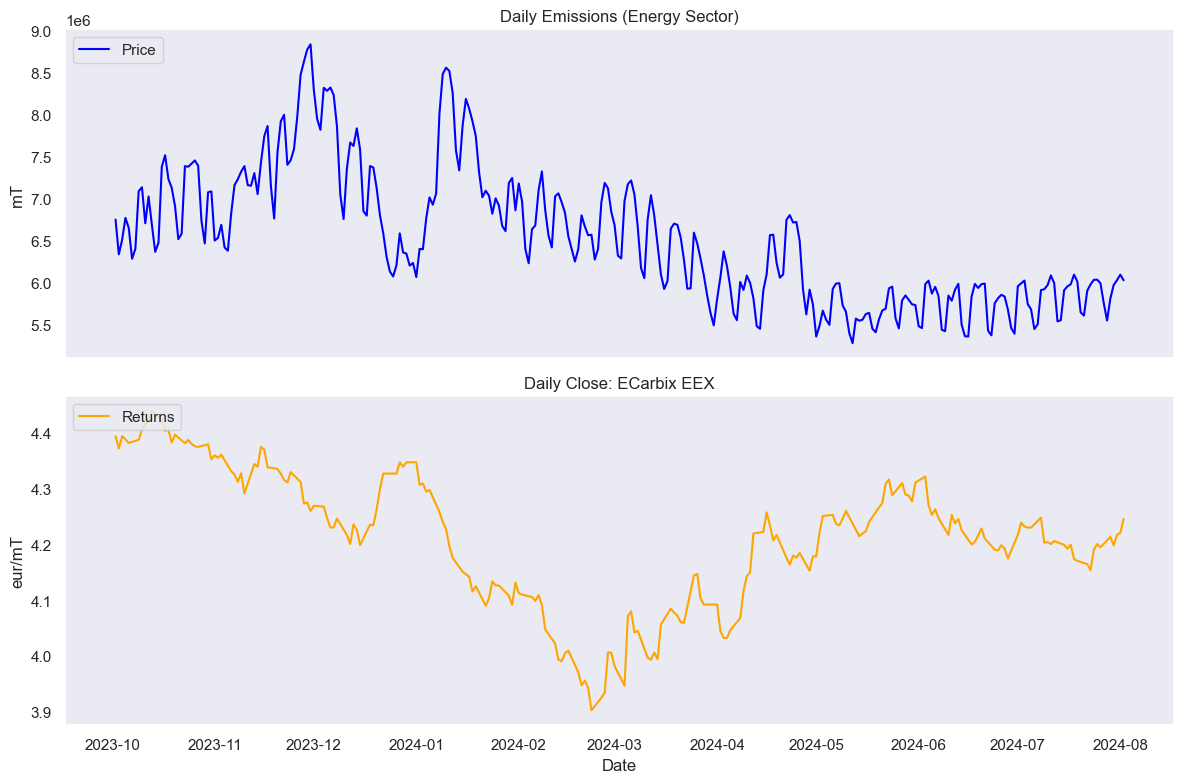

In [85]:
fig, ax1 = plt.subplots(2, 1, figsize=(12,8), sharex = True)
ax1[0].plot(EMV, label='Price', color='blue')
ax1[0].set_title(f'Daily Emissions (Energy Sector)')
ax1[0].set_ylabel('mT')
ax1[0].legend(loc='upper left')
ax1[0].grid()

ax1[1].plot(np.log(Carbon_values), label='Returns', color='orange')
ax1[1].set_title('Daily Close: ECarbix EEX')
ax1[1].set_ylabel('eur/mT')
ax1[1].set_xlabel('Date')
ax1[1].legend(loc='upper left')
ax1[1].grid()

plt.tight_layout()
plt.show()





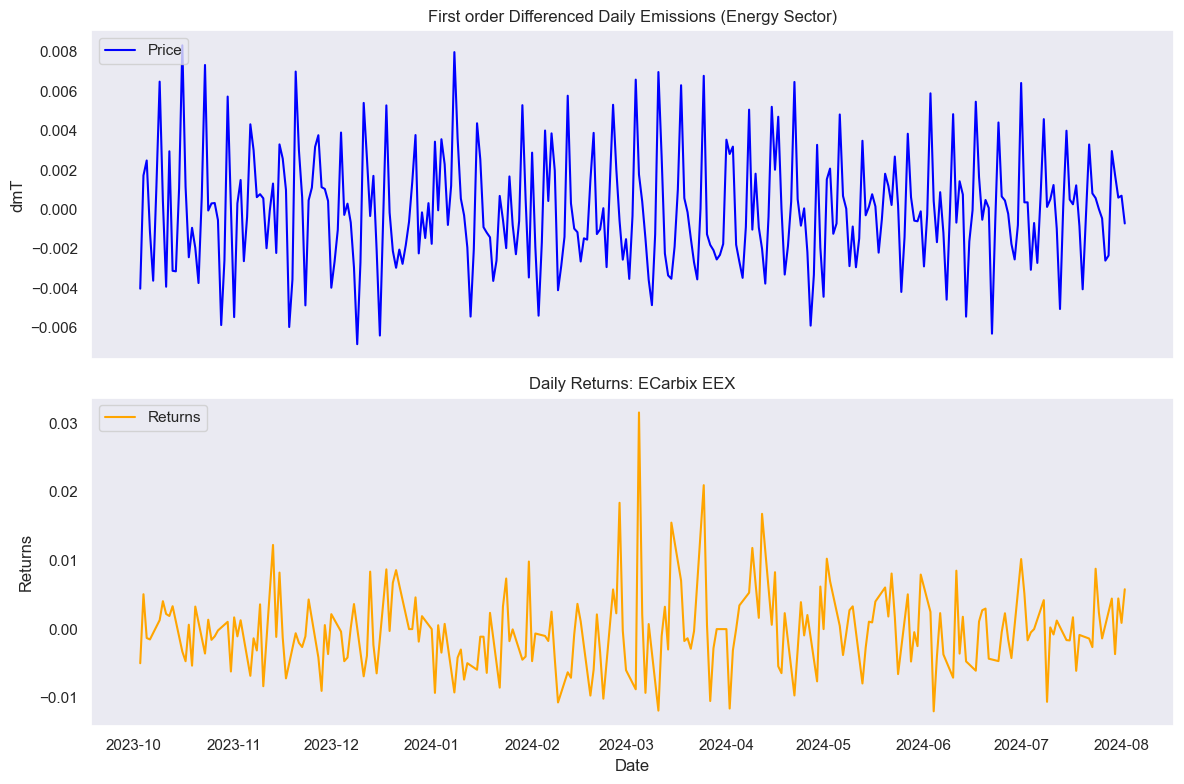

In [56]:
#differencing + plotting
Emissions_diff = np.log(EMV).pct_change().dropna()
Carbon_diff = np.log(Carbon_values).pct_change().dropna()


fig, ax1 = plt.subplots(2, 1, figsize=(12,8), sharex = True)

ax1[0].plot(Emissions_diff, label='Price', color='blue')
ax1[0].set_title(f'First order Differenced Daily Emissions (Energy Sector)')
ax1[0].set_ylabel('dmT')
ax1[0].legend(loc='upper left')
ax1[0].grid()

ax1[1].plot(Carbon_diff, label='Returns', color='orange')
ax1[1].set_title('Daily Returns: ECarbix EEX')
ax1[1].set_ylabel('Returns')
ax1[1].set_xlabel('Date')
ax1[1].legend(loc='upper left')
ax1[1].grid()

plt.tight_layout()
plt.show()


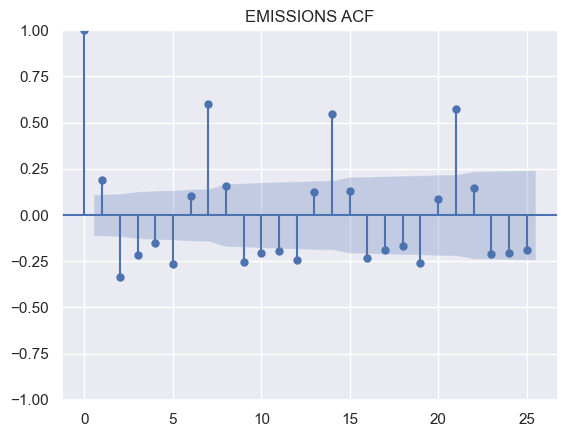

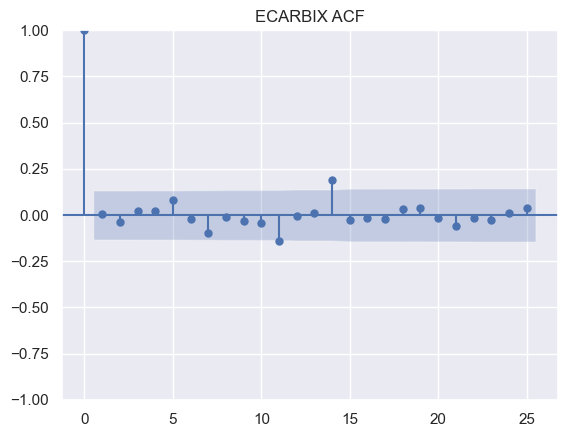

In [61]:
#choose lags for acf plots here
lags = 25

plot_acf(Emissions_diff, lags=lags, title='EMISSIONS ACF')
plot_acf(Carbon_diff, lags=lags, title='ECARBIX ACF');

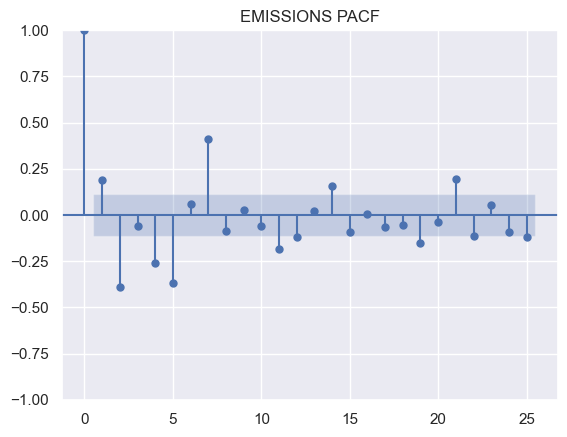

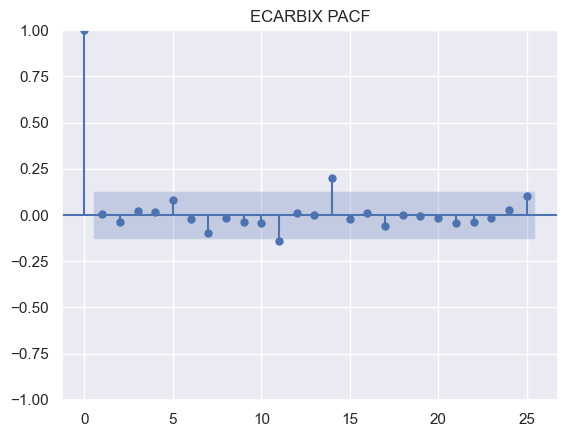

In [60]:
#choose lags for acf plots here
lags = 25

plot_pacf(Emissions_diff, lags=lags, title='EMISSIONS PACF')
plot_pacf(Carbon_diff, lags=lags, title='ECARBIX PACF');

In [216]:
from statsmodels.tsa.stattools import adfuller
#create df and check stationarity

data = pd.DataFrame({
    'ECARBIX' : Carbon_diff,
    'Emissions' : Emissions_diff
})
data = data.fillna(method='ffill')
for column in data.columns:
    result = adfuller(data[column])
    print(f"{column}: p-value = {result[1]}")

ECARBIX: p-value = 1.1952876539054769e-24
Emissions: p-value = 1.9648290291748714e-05


In [219]:
#fit model
VARmodel = VAR(data)
VAR_model = VARmodel.fit(maxlags = 1, ic = 'aic')
print(VAR_model.summary())
#create new dfs

PLOTME1 = pd.DataFrame({
    'Emissions' : EMV,
    'Emissions fit' : VAR_model.fittedvalues.Emissions
})
PLOTME2 = pd.DataFrame({
    'EEX' : Carbon_values,
    'EEX fit' : VAR_model.fittedvalues.ECARBIX})

t1 = PLOTME1[8:]
#10-10-2023 and beyond
t2 = PLOTME2[6:]
#10-10-2023 and beyond
t1
EmUnD = np.log(EMV)
t1a = EmUnD[8:]
FIXED1 = t1['Emissions fit'] + t1a
FIXED1
#exponentiate
fitted_emissions = np.exp(FIXED1)
CaUnD = np.log(Carbon_values)
t2a = CaUnD[6:]
FIXED2 = t2['EEX fit'] + t2a
#exponentiate
fitted_ECB = np.exp(FIXED2)
fitted_ECB
fitted_emissions

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Oct, 2024
Time:                     20:32:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -22.0191
Nobs:                     304.000    HQIC:                  -22.0631
Log likelihood:           2501.34    FPE:                2.54317e-10
AIC:                     -22.0924    Det(Omega_mle):     2.49371e-10
--------------------------------------------------------------------
Results for equation ECARBIX
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000009         0.000323            0.028           0.977
L1.ECARBIX           0.267887         0.055627            4.816           0.000
L1.Emissions        -0.042216         0.112713           -0.37

2023-10-10    7.145764e+06
2023-10-11    6.709713e+06
2023-10-12    7.022242e+06
2023-10-13    6.694945e+06
2023-10-14    6.365391e+06
                  ...     
2024-07-29    5.811461e+06
2024-07-30    5.979231e+06
2024-07-31    6.033084e+06
2024-08-01    6.099044e+06
2024-08-02    6.031540e+06
Freq: D, Length: 298, dtype: float64

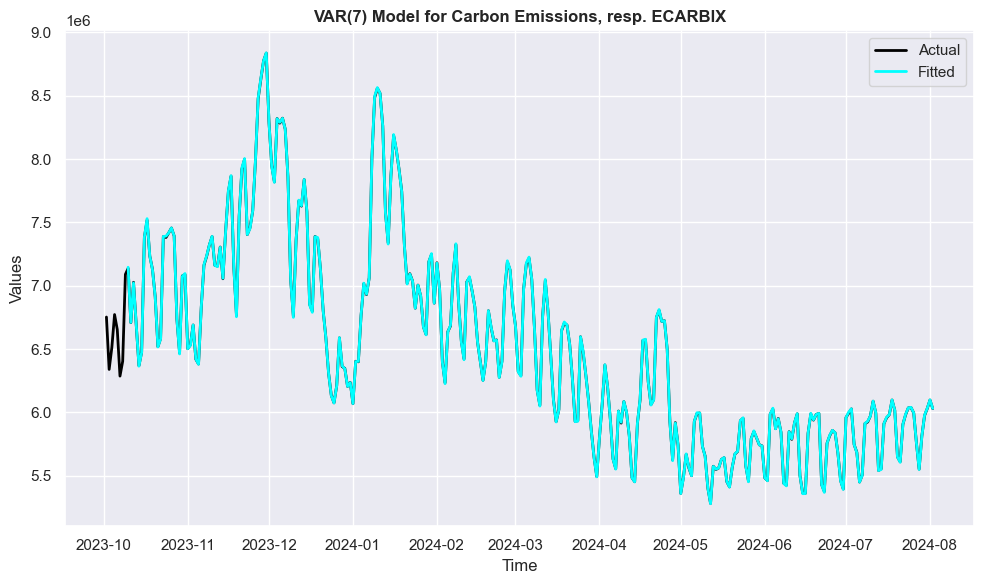

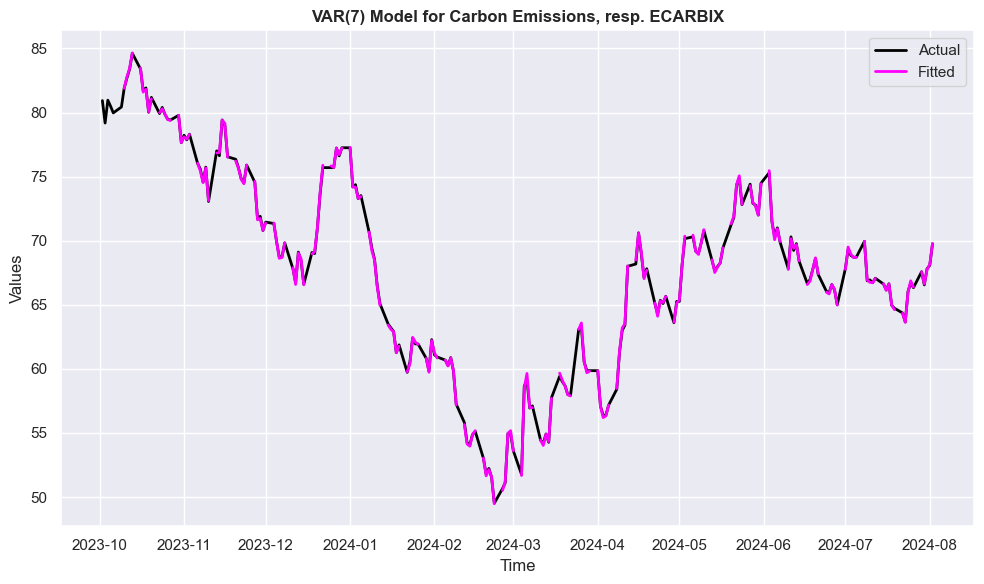

In [220]:
plt.figure(figsize=(10,6))
plt.plot(EMV, label='Actual', color='black', lw=2)
plt.plot(fitted_emissions, label='Fitted', color='cyan', lw=2)
plt.title(f'VAR(7) Model for Carbon Emissions, resp. ECARBIX', fontweight = 'bold')
plt.xlabel('Time')
plt.ylabel('Values')

plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(Carbon_values, label='Actual', color='black', lw=2)
plt.plot(fitted_ECB, label='Fitted', color='magenta', lw=2)
plt.title(f'VAR(7) Model for Carbon Emissions, resp. ECARBIX', fontweight = 'bold')
plt.xlabel('Time')
plt.ylabel('Values')

plt.legend()
plt.tight_layout()
plt.show()

In [215]:
fitted_ECB[2:]

2023-10-10    81.887033
2023-10-11    82.769549
2023-10-12    83.443881
2023-10-13    84.653518
2023-10-14          NaN
                ...    
2024-07-29    67.562656
2024-07-30    66.621664
2024-07-31    67.739422
2024-08-01    68.150411
2024-08-02    69.775542
Length: 298, dtype: float64